In [1]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
from keras import backend as K
from keras.layers import LSTM
from keras.models import Sequential, Model
from keras.layers import Dense, Activation,Input, Add, Masking, Embedding, RepeatVector, BatchNormalization, concatenate, Dropout, TimeDistributed, InputLayer
from keras.optimizers import RMSprop
from keras.regularizers import l2
from generator import Generator
import h5py
import numpy as np
import sys
import os

# Set Tensorflow backend to avoid full GPU pre-loading
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config = config))

Using TensorFlow backend.


In [2]:
def get_model(cnn_feature_size, vocab_size, max_token_len, embedding_dim = 512):
	visibletime = 1
	dummy_model=Sequential()
	dummy_model.add(InputLayer(input_shape=(embedding_dim,), name = 'zero'))
	dummy_model.add(RepeatVector(max_token_len - visibletime))
	print 'lol'

	image_model = Sequential()
	image_model.add(Dense(embedding_dim, input_dim = (2048), activation='elu', name = 'image'))
	image_model.add(BatchNormalization())
	imageout=image_model.output
	imageout=RepeatVector(visibletime)(imageout)
	print 'lol1'

	b=concatenate([imageout,dummy_model.output],axis=1)
	print 'lol2'

	# b = Lambda(lambda x: backend.concatenate([x,mask],axis=1),output_shape=(max_token_len,cnn_feature_size))(imageout)
	# image_model.add(RepeatVector(max_token_len))

	lang_model = Sequential()
# 	lang_model.add(InputLayer(input_shape=(max_token_len), name = 'text'))
# 	lang_model.add(Masking(mask_value=0))
	lang_model.add(Embedding(vocab_size, 256, input_length=max_token_len, name = 'text'))
	lang_model.add(BatchNormalization())
	# lang_model.add(TimeDistributed(Dense(128)))
	lang_model.add(LSTM(256,return_sequences=True))
	lang_model.add(BatchNormalization())
	lang_model.add(Dropout(0.3))
	lang_model.add(TimeDistributed(Dense(embedding_dim)))
	lang_model.add(BatchNormalization())
	print 'lol3'

	intermediate = concatenate([ lang_model.output,b])
	# intermediate = (Dropout(0.1))(intermediate)
	intermediate = LSTM(1024,return_sequences=True,dropout=0.5)(intermediate)
	intermediate = BatchNormalization()(intermediate)
	# intermediate = (Dropout(0.3))(intermediate)
	intermediate = LSTM(1536,return_sequences=True,dropout=0.5)(intermediate)
	intermediate = BatchNormalization()(intermediate)
	intermediate = (Dropout(0.3))(intermediate)
	intermediate = TimeDistributed(Dense(vocab_size,activation='softmax', name='output'))(intermediate)
	print 'lol4'

	model=Model(inputs=[image_model.input,dummy_model.input,lang_model.input],outputs=intermediate)
	print 'lol5'
	# model.summary()
	model.compile('adamax',loss='categorical_crossentropy',metrics=['accuracy'])
	print 'lol6'
	return model

In [3]:
print "Loading Gen"
print "Generating model"
gen = Generator()
# model = get_model(gen.feature_size, gen.vocab_size, gen.max_token_len)

Loading Gen
Generating model


In [4]:
model = get_model(gen.img_feature_size, gen.vocab_size, gen.max_token_len, gen.embedding_size)

lol
lol1
lol2
lol3
lol4
lol5
lol6


In [ ]:
# model.summary()
from keras.models import load_model

# returns a compiled model
# identical to the previous one
model = load_model('../data/notebook_final_model_epoch_100.h5')

In [ ]:
model.summary()

In [8]:
batch_size = 64
print "Start training"
# for i in range(2,16):
model.fit_generator(gen.pullData(), 
                    epochs=5, 
                    steps_per_epoch=int(gen.training_samples_count / batch_size), 
                    shuffle = True, verbose = 1,
#                     workers=8,
#                     use_multiprocessing=True)
                   )
#     print "Saving after epoch:", (i+1)*10
# model.save('../data/notebook_final_2_model_epoch_20.h5')

Start training
Epoch 1/5
632/632 [==============================] - 222s 351ms/step - loss: 0.7177 - acc: 0.1382
Epoch 2/5
632/632 [==============================] - 222s 351ms/step - loss: 0.6813 - acc: 0.1412
Epoch 3/5
632/632 [==============================] - 222s 351ms/step - loss: 0.6425 - acc: 0.1462
Epoch 4/5
632/632 [==============================] - 222s 351ms/step - loss: 0.5992 - acc: 0.1518
Epoch 5/5
632/632 [==============================] - 224s 355ms/step - loss: 0.5732 - acc: 0.1553


In [ ]:
gen.token_to_id['<start>']
# gen.id_to_token[0]

a four wheel drive car is driving through a mud puddle


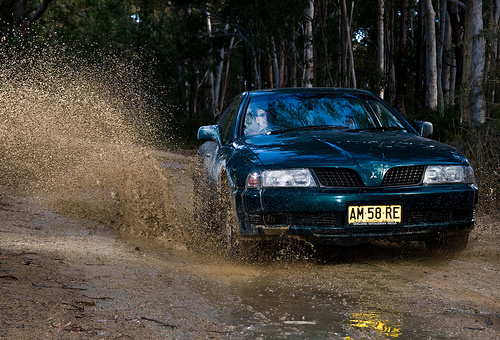

In [10]:
from IPython.display import Image

img_name = '2943023421_e297f05e11.jpg'

feature_dataset = h5py.File('../data/flicker8k/preprocessed/test_features.h5', 'r')
img_features = feature_dataset[img_name]['cnn_features'][:]

# image_filenames = get_image_filenames(dataset_directory + '/' + img_list_file)

# print img_features.shape
features = np.array([img_features])

text_in = np.zeros((1,gen.max_token_len))
text_in[0][:] = np.full((gen.max_token_len,), 0)
text_in[0][0] = 4231

# print features,text_in
arr = []
zeros = np.array([np.zeros(512)])
for arg in range(gen.max_token_len-1):
    pred = model.predict([features, zeros, text_in])
    tok = np.argmax(pred[0][arg])
    word = gen.id_to_token[tok]
    text_in[0][arg+1] = tok
    if word == '<end>':
        break
    arr.append(word)

# arr.append('.')
print ' '.join(arr)
Image(filename= '../data/flicker8k/Flickr8k_Dataset/' + img_name)

In [ ]:
# # model.summary()
# from keras.models import load_model

# # returns a compiled model
# # identical to the previous one
# model = load_model('../data/notebook_final_model_epoch_100.h5')

from IPython.display import Image
import time

with open('../data/flicker8k/preprocessed/test_captions.txt') as captions_file:
    captions = captions_file.read().split('\n')
    
class Caption:
    def __init__(self, name):
        self.name = name
        self.captions = ['','','','','']
        self.result = ''
        
    def add(self, caption_number, caption):
        self.captions[caption_number] = caption
        
test_results = {}

for caption in captions:
    if len(caption) < 5:
        continue
    caption = caption.split('\t')
    img_name = caption[0].split('#')
    caption_number = int(img_name[1])
    img_name = img_name[0]
    caption = caption[1].lower()
    
    try:
        cap_obj = test_results[img_name]
        cap_obj.add(caption_number, caption)
    except Exception as e:
#         print str(e)
        feature_dataset = h5py.File('../data/flicker8k/preprocessed/test_features.h5', 'r')
        img_features = feature_dataset[img_name]['cnn_features'][:]

        # image_filenames = get_image_filenames(dataset_directory + '/' + img_list_file)

        # print img_features.shape
        features = np.array([img_features])

        text_in = np.zeros((1,gen.max_token_len))
        text_in[0][:] = np.full((gen.max_token_len,), 0)
        text_in[0][0] = 4230

        # print features,text_in
        arr = []
        zeros = np.array([np.zeros(512)])
        for arg in range(gen.max_token_len-1):
            pred = model.predict([features, zeros, text_in])
            tok = np.argmax(pred[0][arg])
            word = gen.id_to_token[tok]
            text_in[0][arg+1] = tok
            if word == '<end>':
                break
            arr.append(word)

        arr.append('.')
        cap_obj = Caption(img_name)
        cap_obj.add(caption_number, caption)
        cap_obj.result = ' '.join(arr)
        test_results.update({img_name: cap_obj})
        print self.result
        Image(filename= '../data/flicker8k/Flickr8k_Dataset/' + img_name)
        time.sleep(1)

In [ ]:
len(test_results)

In [ ]:
test_results['2943023421_e297f05e11.jpg'].captions

In [ ]:
import pickle
pickle.dump(test_results, open('../data/flicker8k/preprocessed/test_results.p', 'wb') )

In [ ]:
captions[3].split('\t')

In [ ]:
import pickle

class Caption:
    def __init__(self, name):
        self.name = name
        self.captions = ['','','','','']
        self.result = ''
        
    def add(self, caption_number, caption):
        self.captions[caption_number] = caption
        
test_results = pickle.load(open('../data/flicker8k/preprocessed/test_results.p', 'rb'))

for img_name in test_results:
    ground_truth = test_results[img_name].captions
    result = test_results[img_name].result